In [11]:
import os
from joblib import dump

# Helper functions for data preprocessing and feature extraction
from methods.preprocessing import *
from methods.image_enhancement import *

# Machine Learning models and utilities
from methods.ml import *

# CNN models and utilities
from methods.cnn import *

# 1. Preprocessing and EDA (Exploratory Data Analysis)

In [12]:
# Read data in folder
train_dir = "/Users/dogukan/Developer/facerecognation/data/fer-2013-dataset/train"
for dirpath,dirname,filenames in os.walk(train_dir):
    print(f"There are {len(dirname)} directories and {len(filenames)} images in {dirpath[22:]}")

There are 7 directories and 0 images in er/facerecognation/data/fer-2013-dataset/train
There are 0 directories and 7215 images in er/facerecognation/data/fer-2013-dataset/train/happy
There are 0 directories and 4830 images in er/facerecognation/data/fer-2013-dataset/train/sad
There are 0 directories and 4097 images in er/facerecognation/data/fer-2013-dataset/train/fear
There are 0 directories and 3171 images in er/facerecognation/data/fer-2013-dataset/train/surprise
There are 0 directories and 4965 images in er/facerecognation/data/fer-2013-dataset/train/neutral
There are 0 directories and 3995 images in er/facerecognation/data/fer-2013-dataset/train/angry
There are 0 directories and 436 images in er/facerecognation/data/fer-2013-dataset/train/disgust


In [13]:
data_gen = create_data_gen()
train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical"
)

Found 28709 images belonging to 7 classes.


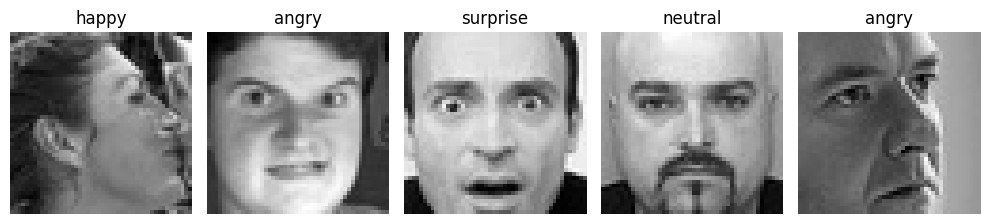

In [14]:
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())

images, labels = next(train_generator)
plot_example_images(images[:5], labels[:5], label_map)

# 2. Traditional Image Processing/Enhancement

Optionally, enhance images or extract features.\
Traditional image processing and enhancement techniques are foundational to improving the quality of images for various applications, from medical imaging to photography.\
In our project, we modeled many of these techniques in the "image_enhancement.py" file. These are,
- Image inpainting
- Linear filtering, smoothing
- Histogram equalization
- ...

[ WARN:0@501.132] global loadsave.cpp:248 findDecoder imread_('../data/fer-2013-data/train/angry/Training_6640570.jpg'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

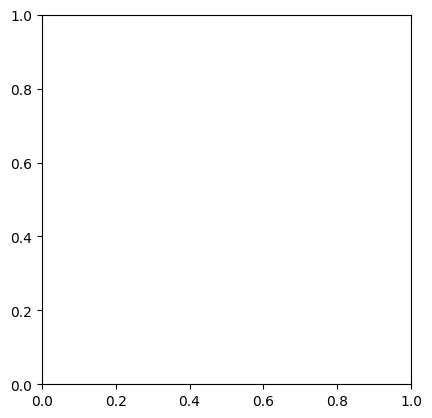

In [15]:
# This is an example image to show our enhancements on images
#improvable_image_path = "../data/fer-2013-data/train/angry/Training_2861857.jpg"
improvable_image_path = "../data/fer-2013-data/train/angry/Training_6640570.jpg"
show_image_as_plot(image_path=improvable_image_path)

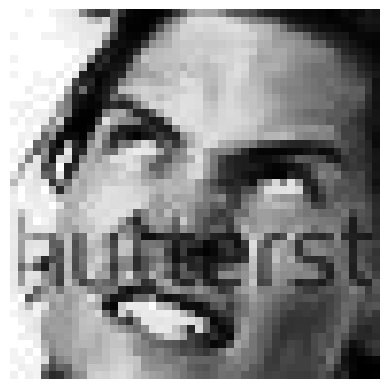

In [ ]:
hist_equalized_image = histogram_equalization(image_path=improvable_image_path)
show_image_as_plot(image=hist_equalized_image)

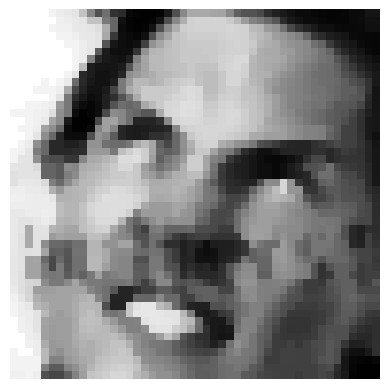

In [ ]:
median_blur_image = reduce_noise_median(image=hist_equalized_image)
show_image_as_plot(image=median_blur_image)

# 3. Feature Matching

Feature matching is widely used in machine learning models.
In our project, we modeled two of these techniques in the "image_enhancement.py" file. These are,
- SIFT
- HOG

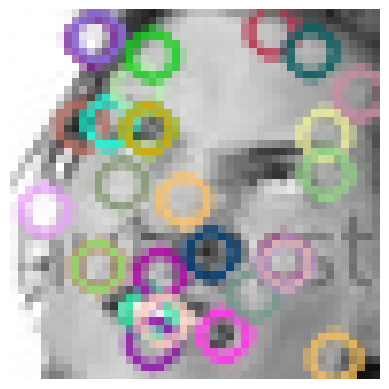

In [ ]:
sift_img, _= sift_creator(image_path=improvable_image_path)
show_image_as_plot(image=sift_img)

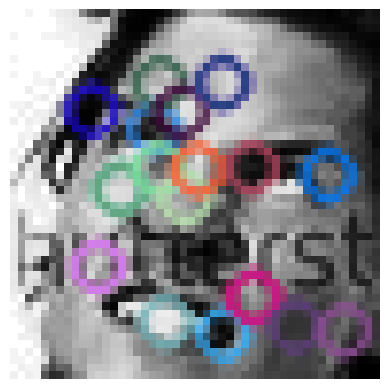

In [ ]:
sift_img, _= sift_creator(image=hist_equalized_image)
show_image_as_plot(image=sift_img)

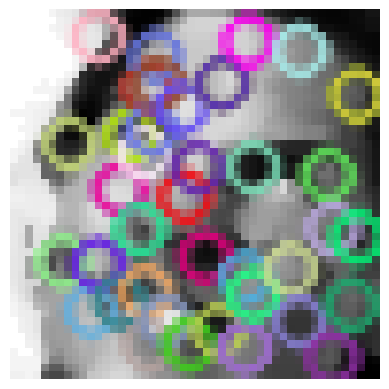

In [ ]:
sift_img, _= sift_creator(image=median_blur_image)
show_image_as_plot(image=sift_img)

# 4. ML Models

We will train 3 different ML models and compare them.
- SVM
- KNN
- Random Forest

Improving model accuracy through techniques such as feature matching and cross-validation, which are crucial for assessing the performance of machine learning models like SVM, KNN, and Random Forest in a more robust manner.

In [ ]:
# Load train dataset
images_train, labels_train = load_dataset(train_dir)

# Labels NumPy array
y_train = np.array(labels_train)

# Extract SIFT features
sift_features_train = extract_sift_features(images_train)
X_train_sift = np.array(sift_features_train)

# Extract HOG features
hog_features_train = extract_HOG_features(images_train)
X_train_hog = np.array(hog_features_train)

# Combine SIFT and HOG features
combined_features_train = combine_features(sift_features_train, hog_features_train)
X_train_combined = np.array(combined_features_train)

4.1. SVM (Support Vector Machine)

In [ ]:
# sift + svm training
svm_classifier_sift = SVMClassifier()
svm_classifier_sift.train(X_train_sift, y_train)

# Save the trained model to a file
dump(svm_classifier_sift, "svm_classifier_sift.joblib")

In [ ]:
# hog + svm training
svm_classifier_hog = SVMClassifier()
svm_classifier_hog.train(X_train_hog, y_train)

# Save the trained model to a file
dump(svm_classifier_sift, "svm_classifier_hog.joblib")

In [ ]:
# combined + svm training
svm_classifier_combined = SVMClassifier()
svm_classifier_combined.train(X_train_combined, y_train)

# Save the trained model to a file
dump(svm_classifier_combined, "svm_classifier_combined.joblib")

4.2 KNN (K-Nearest Neighbors)

In [ ]:
# sift + knn training
knn_classifier_sift = KNNClassifier()
knn_classifier_sift.train(X_train_sift, y_train)

# Save the trained model to a file
dump(knn_classifier_sift, "knn_classifier_sift.joblib")

In [ ]:
# hog + knn training
knn_classifier_hog = KNNClassifier()
knn_classifier_hog.train(X_train_hog, y_train)

# Save the trained model to a file
dump(knn_classifier_hog, "knn_classifier_hog.joblib")

In [ ]:
# combined + knn training
knn_classifier_combined = KNNClassifier()
knn_classifier_combined.train(X_train_combined, y_train)

# Save the trained model to a file
dump(knn_classifier_combined, "knn_classifier_combined.joblib")

4.3 Random Forest

In [ ]:
# sift + random forest training
rf_classifier_sift = RandomForestClassifier()
rf_classifier_sift.train(X_train_sift, y_train)

# Save the trained model to a file
dump(rf_classifier_sift, "rf_classifier_sift.joblib")

In [ ]:
# hog + random forest training
rf_classifier_hog = RandomForestClassifier()
rf_classifier_hog.train(X_train_hog, y_train)

# Save the trained model to a file
dump(rf_classifier_hog, "rf_classifier_hog.joblib")

In [ ]:
# combined + random forest training
rf_classifier_combined = RandomForestClassifier()
rf_classifier_combined.train(X_train_combined, y_train)

# Save the trained model to a file
dump(rf_classifier_combined, "rf_classifier_combined.joblib")

# 5. CNN Models

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir = '/Users/dogukan/Developer/facerecognation/data/fer-2013-dataset/train'  # Update this path
data_gen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.2,
                              height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                              horizontal_flip=True, fill_mode='nearest')

train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical"
)

def create_model(input_shape=(48, 48, 1), num_classes=7):

    model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, train_generator, validation_generator=None, epochs=50):

    if validation_generator:
        history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)
    else:
        history = model.fit(train_generator, epochs=epochs)

    return history

model = create_model()

history = train_model(model, train_generator, epochs=50)

training_accuracy = history.history['accuracy'][-1]
print(f"Training Accuracy: {training_accuracy*100:.2f}%")

if 'val_accuracy' in history.history:
    validation_accuracy = history.history['val_accuracy'][-1]
    print(f"Validation Accuracy: {validation_accuracy*100:.2f}%")